# GraCAM Overlay

- Import the required Libraries
- I have cloned the [Tensorflow Model Garden](https://github.com/tensorflow/models), and finetuned a ResNet50 model (Pretrained on ImageNet) on (Cats & Dogs) dataset. 
- Refer to my other repo [vit_resnet_finetuning](https://github.com/shashank3009/vit_resnet_finetuning) for more information on how to finetune a model using Tensorflow Model Graden

In [ ]:
import sys
sys.path.append('/home/shashank/tfgarden/models')

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import tensorflow as tf


import tensorflow_models as tfm
import yaml

from official.vision.modeling.backbones import resnet
from official.vision.modeling import classification_model

import matplotlib.pyplot as plt
%matplotlib inline

2025-05-19 10:50:49.942539: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747632050.627839   23921 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747632050.827343   23921 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-19 10:50:53.979742: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


- Import the config used to finetune the ResNet50 model

In [2]:
config = tfm.core.exp_factory.get_exp_config('resnet_imagenet')

config_path = "/home/shashank/repos/gradCAM/model_experiments/resnet_baseline_bs16/export/params.yaml"
with open(config_path, "r") as file:
    override_params = yaml.full_load(file)
config.override(override_params, is_strict=False)

- Build the model along with the backbone (Resnet) using the imported config

In [3]:
# Build ResNet backbone from config
resnet_backbone = resnet.ResNet(
    model_id=config.task.model.backbone.resnet.model_id,
    stem_type=config.task.model.backbone.resnet.stem_type,
    se_ratio=config.task.model.backbone.resnet.se_ratio,
    input_specs=tf.keras.layers.InputSpec(shape=[None, 224, 224, 3]),
    bn_trainable=True
)

# Create the classification model
model = classification_model.ClassificationModel(
    backbone=resnet_backbone,
    num_classes=config.task.model.num_classes,
    input_specs=tf.keras.layers.InputSpec(shape=[None, 224, 224, 3]),
    dropout_rate=config.task.model.dropout_rate,
    kernel_initializer='he_normal'
)

I0000 00:00:1747594943.425083 2475580 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 807 MB memory:  -> device: 0, name: NVIDIA TITAN Xp, pci bus id: 0000:03:00.0, compute capability: 6.1


- Build the model and load the weights from the finetuned checkpoint

In [ ]:
model.build([None, 224, 224, 3])
checkpoint = tf.train.Checkpoint(model=model)
checkpoint.restore('/home/shashank/repos/gradCAM/model_experiments/resnet_baseline_bs16/ckpt-20000').expect_partial()

- Print the model summary

In [6]:
model.summary()

Model: "classification_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 res_net (ResNet)            {'2': (None, 56, 56, 25   23561152  
                             6),                                 
                              '3': (None, 28, 28, 51             
                             2),                                 
                              '4': (None, 14, 14, 10             
                             24),                                
                              '5': (None, 7, 7, 2048             
                             )}                                  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                      

- Import the image to infer

In [7]:
img_path = "/home/shashank/tensorflow_datasets/downloads/cats_and_dogs/test/cat/cat.4001.jpg"
img_array = tf.keras.utils.img_to_array(tf.keras.utils.load_img(img_path, target_size=(224, 224)))
img_array = tf.cast(img_array[tf.newaxis, ...], dtype=tf.float32)

- Get the feature maps from the last convolutional block.
- Apply all the sequential layers to the feature map to get the model output
- Collect the class specific score from the model output
- Use the gradient tape to differentiate class score with respect to the all values in the feature map

In [ ]:
with tf.GradientTape() as tape:
    
    tape.watch(img_array)

    feature_maps = resnet_backbone(img_array)['5'] # (None, 7, 7, 2048)
    pooling = model.get_layer("global_average_pooling2d")(feature_maps)
    dropout = model.get_layer("dropout")(pooling, training=False)
    prediction = model.get_layer("dense")(dropout, training=False) # (None, 2)

    class_idx = 0 # Cat Index
    class_score = prediction[:,class_idx]
    
grads = tape.gradient(class_score, feature_maps)

I0000 00:00:1747594948.717643 2475580 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-05-19 00:32:30.331431: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.08GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-05-19 00:32:30.526322: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 602.12MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


- Average out the gradient along the width and height, and multiple it with the feature maps
- Then average out the weighted feature map along the channel
- Normalize the feature map by dividing it with the max value

In [9]:
weighted_feature_maps = feature_maps[0] * tf.reduce_mean(grads, axis=(0,1,2))[tf.newaxis, tf.newaxis]
weighted_feature_maps = tf.reduce_mean(weighted_feature_maps, axis=(-1))
weighted_feature_maps = weighted_feature_maps.numpy()
weighted_feature_maps /= np.max(weighted_feature_maps)

- Convert the heatmap using RGB colormap (jet) or any other colormap
- Normalize the original image to infer to have the values between 0 & 1
- Add the weighted original image and weighted RGB heatmap to get the superimposed image

In [ ]:
heatmap = weighted_feature_maps
heatmap = tf.image.resize(heatmap[..., tf.newaxis], (224,224))
heatmap = tf.squeeze(heatmap)

colormap = plt.cm.get_cmap('jet')
heatmap_rgb = colormap(heatmap.numpy())

# Drop alpha channel, keep RGB
heatmap_rgb = heatmap_rgb[..., :3]
original_image = tf.cast(img_array, tf.float32) / 255.0

# Superimpose heatmap on original image
superimposed_img = 0.6 * heatmap_rgb + 0.4 * original_image[0].numpy()

original_image = tf.clip_by_value(original_image, 0.0, 1.0).numpy()
superimposed_img = tf.clip_by_value(superimposed_img, 0.0, 1.0).numpy()

- Left image is the original image, and Right image is the superimposed image
- Red part signifies where the model is focusing while making the decision
- We can see that it is focusing on majority of cat body while classifying the image as Cat

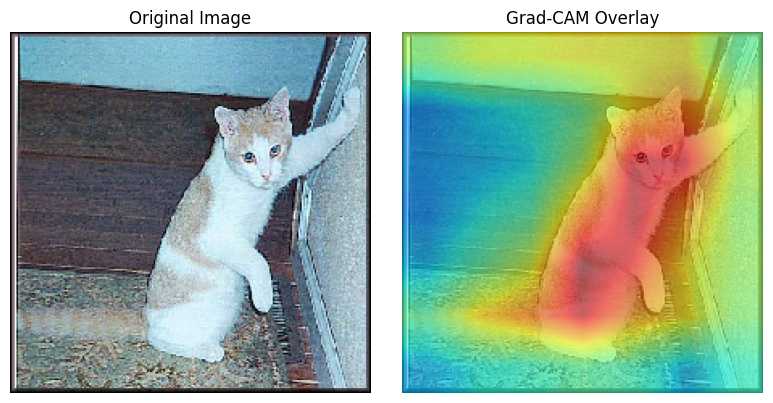

In [ ]:
# Plot
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# Subplot (0,0): Original Image
axes[0].imshow(original_image[0])
axes[0].axis('off')
axes[0].set_title('Original Image')

# Subplot (0,1): GradCAM Overlay
axes[1].imshow(superimposed_img)
axes[1].axis('off')
axes[1].set_title('Grad-CAM Overlay')

plt.tight_layout()
plt.show()